In [112]:
import os
import sys
import math
import sqlite3
import argparse
import warnings
import json
import random
from collections import Counter
from itertools import combinations
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX


from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


from networkx.algorithms.community import greedy_modularity_communities, label_propagation_communities


warnings.filterwarnings("ignore")

In [114]:
# Connect to the database
conn = sqlite3.connect("accident_data_v1.0.0_2023.db")

# Print all table names
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in the database:")
print(tables)

# Load and print the accident table
acc = pd.read_sql_query("SELECT * FROM accident", conn)
print("\nColumns in 'accident' table:")
print(acc.columns)

Tables in the database:
       name
0  accident
1  casualty
2   vehicle
3      lsoa

Columns in 'accident' table:
Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_acc

In [115]:
cas_df = pd.read_sql_query("SELECT * FROM casualty", conn)
cas_df
cas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600332 entries, 0 to 600331
Data columns (total 19 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   casualty_index                      600332 non-null  int64 
 1   accident_index                      600332 non-null  object
 2   accident_year                       600332 non-null  int64 
 3   accident_reference                  600332 non-null  object
 4   vehicle_reference                   600332 non-null  int64 
 5   casualty_reference                  600332 non-null  int64 
 6   casualty_class                      600332 non-null  int64 
 7   sex_of_casualty                     600332 non-null  int64 
 8   age_of_casualty                     600332 non-null  int64 
 9   age_band_of_casualty                600332 non-null  int64 
 10  casualty_severity                   600332 non-null  int64 
 11  pedestrian_location                 600

In [116]:
veh_df = pd.read_sql_query("SELECT * FROM vehicle", conn)
veh_df
veh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849091 entries, 0 to 849090
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   vehicle_index                     849091 non-null  int64 
 1   accident_index                    849091 non-null  object
 2   accident_year                     849091 non-null  int64 
 3   accident_reference                849091 non-null  object
 4   vehicle_reference                 849091 non-null  int64 
 5   vehicle_type                      849091 non-null  int64 
 6   towing_and_articulation           849091 non-null  int64 
 7   vehicle_manoeuvre                 849091 non-null  int64 
 8   vehicle_direction_from            849091 non-null  int64 
 9   vehicle_direction_to              849091 non-null  int64 
 10  vehicle_location_restricted_lane  849091 non-null  int64 
 11  junction_location                 849091 non-null  int64 
 12  sk

In [117]:
lsoa_df = pd.read_sql_query("SELECT * FROM LSOA", conn)
lsoa_df
lsoa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34378 entries, 0 to 34377
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   objectid       34378 non-null  int64  
 1   lsoa01cd       34378 non-null  object 
 2   lsoa01nm       34378 non-null  object 
 3   lsoa01nmw      34378 non-null  object 
 4   shape__area    34378 non-null  float64
 5   shape__length  34378 non-null  float64
 6   globalid       34378 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.8+ MB


In [118]:
try:
    # Query to get youngest and oldest driver/rider with valid age (≥ 16)
    age_df = pd.read_sql_query("""
        SELECT 
            MIN(age_of_casualty) AS youngest_driver,
            MAX(age_of_casualty) AS oldest_driver
        FROM casualty
        WHERE 
            casualty_class = 1
            AND age_of_casualty IS NOT NULL
            AND age_of_casualty >= 16;
    """, conn)

    if age_df.empty or age_df.isnull().values.any():
        print("Warning: No valid age data found for drivers/riders.")
    else:
        youngest = int(age_df.loc[0, 'youngest_driver'])
        oldest = int(age_df.loc[0, 'oldest_driver'])
        print(f"Youngest Driver/Rider: {youngest} years")
        print(f"Oldest Driver/Rider: {oldest} years")

except Exception as e:
    print(f"Error retrieving driver age data: {e}")

age_df

Youngest Driver/Rider: 16 years
Oldest Driver/Rider: 101 years


,youngest_driver,oldest_driver
0,16,101


In [119]:
try:
    # Query to count all vehicles with type 19
    count_df = pd.read_sql_query("""
        SELECT COUNT(*) AS type_19_count
        FROM vehicle
        WHERE vehicle_type = 19;
    """, conn)

    if count_df.empty or count_df['type_19_count'].isnull().all():
        print("Warning: No data found for vehicle_type = 19.")
    else:
        type_19_count = int(count_df.loc[0, 'type_19_count'])
        print(f"Total number of vehicles with type 19: {type_19_count}")

except Exception as e:
    print(f"Error retrieving vehicle type data: {e}")

count_df

Total number of vehicles with type 19: 47458


,type_19_count
0,47458


In [120]:
try:
    hull_df = pd.read_sql_query("""
        SELECT 
            v.sex_of_driver,
            c.sex_of_casualty,
            a.speed_limit,
            v.age_of_vehicle
        FROM accident a
        JOIN vehicle v ON a.accident_index = v.accident_index
        JOIN casualty c ON a.accident_index = c.accident_index
        JOIN lsoa l ON a.lsoa_of_accident_location = l.lsoa01cd
        WHERE l.lsoa01nm LIKE '%Kingston upon Hull%';
    """, conn)

    if hull_df.empty:
        print("No accident records found for Kingston Upon Hull.")
    else:
        print("Kingston Upon Hull Accident Data (Sample):")
        print(hull_df.head())

except Exception as e:
    print(f"Error retrieving data: {e}")

hull_df

Kingston Upon Hull Accident Data (Sample):
   sex_of_driver  sex_of_casualty  speed_limit  age_of_vehicle
0              1                1           30              13
1              1                1           30               9
2              3                1           30               6
3              3                2           30               6
4              1                1           30              11


,sex_of_driver,sex_of_casualty,speed_limit,age_of_vehicle
0,1,1,30,13
1,1,1,30,9
2,3,1,30,6
3,3,2,30,6
4,1,1,30,11
...,...,...,...,...
6382,1,1,30,-1
6383,1,1,30,-1
6384,1,1,30,-1
6385,3,1,30,-1


In [121]:
print(acc.columns)

Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location'],
      dtype='object')


## Peak times for accidents

In [123]:
acc = pd.read_sql("""
    SELECT time, date, day_of_week, accident_severity, local_authority_district
    FROM accident
    WHERE accident_year = 2019
""", conn)

In [124]:
severity_map = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}
acc['accident_severity'] = acc['accident_severity'].map(severity_map)

In [125]:
acc['hour'] = pd.to_datetime(acc['time'], format='%H:%M', errors='coerce').dt.hour
hour_sev_counts = acc.groupby(['hour', 'accident_severity']).size().unstack(fill_value=0)

In [126]:
print("Accidents by Hour and Severity:")
print(hour_sev_counts)

Accidents by Hour and Severity:
accident_severity  Fatal  Serious  Slight
hour                                     
0                     58      456    1379
1                     39      329     959
2                     30      253     683
3                     28      204     595
4                     25      192     574
5                     38      268     863
6                     53      491    1860
7                     42     1022    4289
8                     43     1310    6774
9                     73      915    4509
10                    81     1028    4081
11                    87     1163    4710
12                    91     1201    5309
13                    91     1304    5551
14                   106     1300    5588
15                   107     1810    7255
16                   111     1822    7529
17                    99     1948    8151
18                   100     1576    6671
19                    70     1300    4864
20                    74      938    3524
21

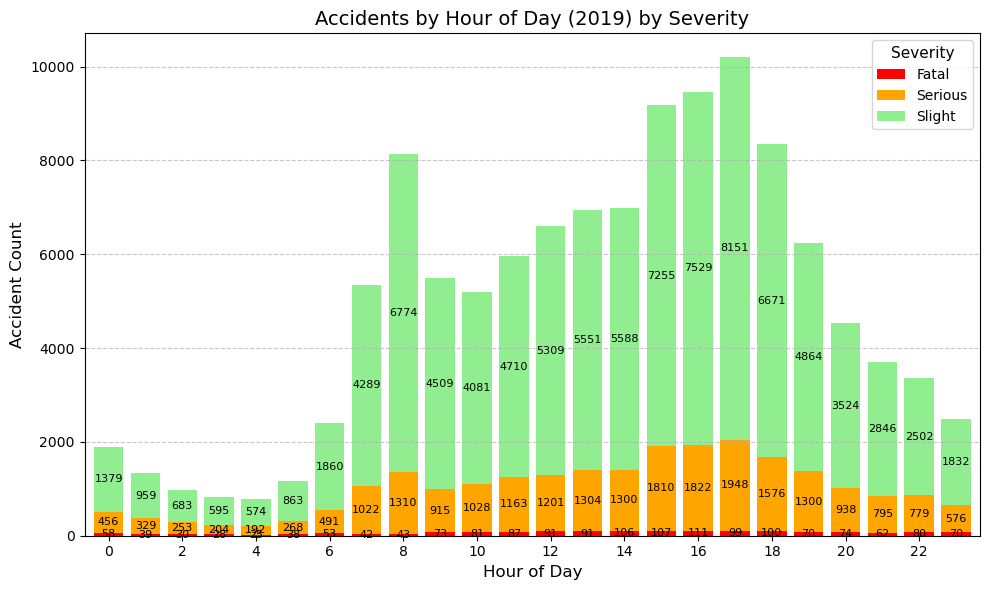

In [127]:
plt.figure(figsize=(10,6))
ax = hour_sev_counts.plot(
    kind='bar',
    stacked=True,
    color=['red','orange','lightgreen'],
    width=0.8,
    ax=plt.gca()
)

# Add count labels on top of each segment
for i, hour in enumerate(hour_sev_counts.index):
    bottom = 0
    for sev in hour_sev_counts.columns:
        count = hour_sev_counts.loc[hour, sev]
        if count > 0:
            ax.text(i, bottom + count/2, str(count), ha='center', va='center', fontsize=8, color='black')
            bottom += count

plt.title("Accidents by Hour of Day (2019) by Severity", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Accident Count", fontsize=12)
plt.xticks(range(0,24,2), rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Severity", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.savefig('accidents_by_hour_severity.png', dpi=300)
plt.show()

In [128]:
day_sev_counts = acc.groupby(['day_of_week', 'accident_severity']).size().unstack(fill_value=0)

# Ensure days are ordered Monday → Sunday
days = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
weekday_counts = [day_sev_counts.loc[i] if i in day_sev_counts.index else pd.Series([0,0,0], index=['Fatal','Serious','Slight']) for i in range(1,8)]
weekday_counts_df = pd.DataFrame(weekday_counts, index=days)

# Print the values
print("\nAccidents by Day of Week and Severity:")
print(weekday_counts_df)


Accidents by Day of Week and Severity:
accident_severity  Fatal  Serious  Slight
Sun                  238     2897    9800
Mon                  224     3136   13283
Tue                  237     3283   14078
Wed                  238     3364   14173
Thu                  225     3470   14278
Fri                  236     3615   15205
Sat                  260     3215   12081


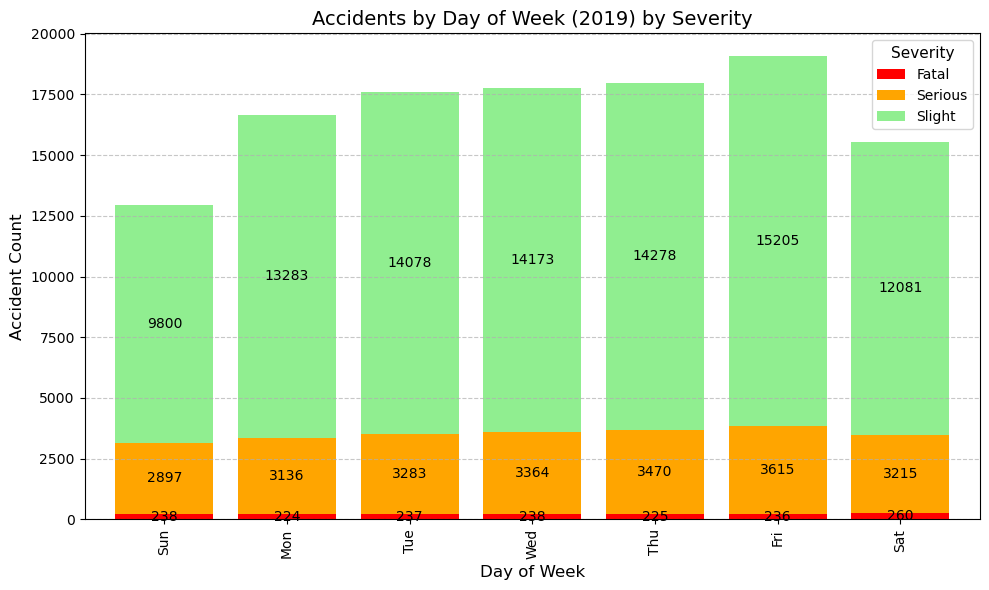

In [129]:
# Plot stacked bar chart
plt.figure(figsize=(10,6))
ax = weekday_counts_df.plot(
    kind='bar',
    stacked=True,
    color=['red','orange','lightgreen'],
    width=0.8,
    ax=plt.gca()
)

# Add count labels on each segment
for i, day in enumerate(weekday_counts_df.index):
    bottom = 0
    for sev in weekday_counts_df.columns:
        count = weekday_counts_df.loc[day, sev]
        if count > 0:
            ax.text(i, bottom + count/2, str(count), ha='center', va='center', fontsize=10, color='black')
            bottom += count

plt.title("Accidents by Day of Week (2019) by Severity", fontsize=14)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Accident Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Severity", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.savefig('accidents_by_day_severity.png', dpi=300)
plt.show()

In [130]:
severity_counts = acc['accident_severity'].value_counts()

# Print the counts
print("\nOverall Accident Severity Counts:")
print(severity_counts)


Overall Accident Severity Counts:
accident_severity
Slight     92898
Serious    22980
Fatal       1658
Name: count, dtype: int64


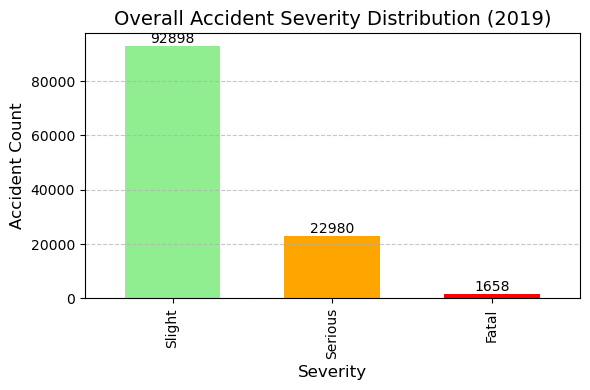

In [131]:
# Plot bar chart
plt.figure(figsize=(6,4))
ax = severity_counts.plot(
    kind='bar',
    color=['lightgreen','orange','red'],
    width=0.6
)

# Add counts on top of each bar
for i, count in enumerate(severity_counts):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

plt.title("Overall Accident Severity Distribution (2019)", fontsize=14)
plt.xlabel("Severity", fontsize=12)
plt.ylabel("Accident Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('accidents_by_severity.png', dpi=300)
plt.show()

In [132]:
# Query accidents involving motorcycles by engine size
cat_conditions = {'≤125cc':   "engine_capacity_cc <= 125 AND vehicle_type IN (2,3,4) AND accident_year = 2019",
'126–500cc':"engine_capacity_cc BETWEEN 126 AND 500 AND vehicle_type IN (2,3,4) AND accident_year = 2019",
'>500cc':   "engine_capacity_cc > 500 AND vehicle_type IN (2,3,4) AND accident_year = 2019"}

In [133]:
heat_data = pd.DataFrame()
heat_data_day = pd.DataFrame()

for label, cond in cat_conditions.items():
    df = pd.read_sql(f"""
        SELECT a.time, a.day_of_week, a. accident_severity
        FROM accident a
        JOIN (
            SELECT DISTINCT accident_index 
            FROM vehicle
            WHERE {cond}
        ) v ON a.accident_index = v.accident_index
        WHERE a.accident_year = 2019
    """, conn)

    # Hourly counts 
    df['hour'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce').dt.hour
    counts_hour = df['hour'].value_counts().sort_index()
    heat_data[label] = counts_hour

    # Day-of-week counts 
    weekday_counts = df['day_of_week'].value_counts().sort_index()
    counts_day = [weekday_counts.get(i, 0) for i in range(1, 8)]
    heat_data_day[label] = counts_day



# Clean up hour index
heat_data = heat_data.fillna(0).sort_index()
heat_data.index.name = 'Hour of Day'

# Add day labels
days = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
heat_data_day.index = days

#  Print results 
print("Accident Counts by Hour and Motorcycle Engine Size (2019):")
print(heat_data.astype(int))

print("\nAccident Counts by Day of Week and Motorcycle Engine Size (2019):")
print(heat_data_day.astype(int))

Accident Counts by Hour and Motorcycle Engine Size (2019):
             ≤125cc  126–500cc  >500cc
Hour of Day                           
0               135          4       2
1                88          3       1
2                62          4       0
3                32          0       2
4                44          2       1
5                80          9       3
6               184          8      15
7               452         43      32
8               562         45      42
9               349         31      24
10              338         27      30
11              400         37      35
12              507         48      41
13              584         46      32
14              579         56      44
15              714         50      55
16              844         72      57
17              981         81      60
18              871         61      49
19              707         43      29
20              535         20      26
21              451         19      17
22   

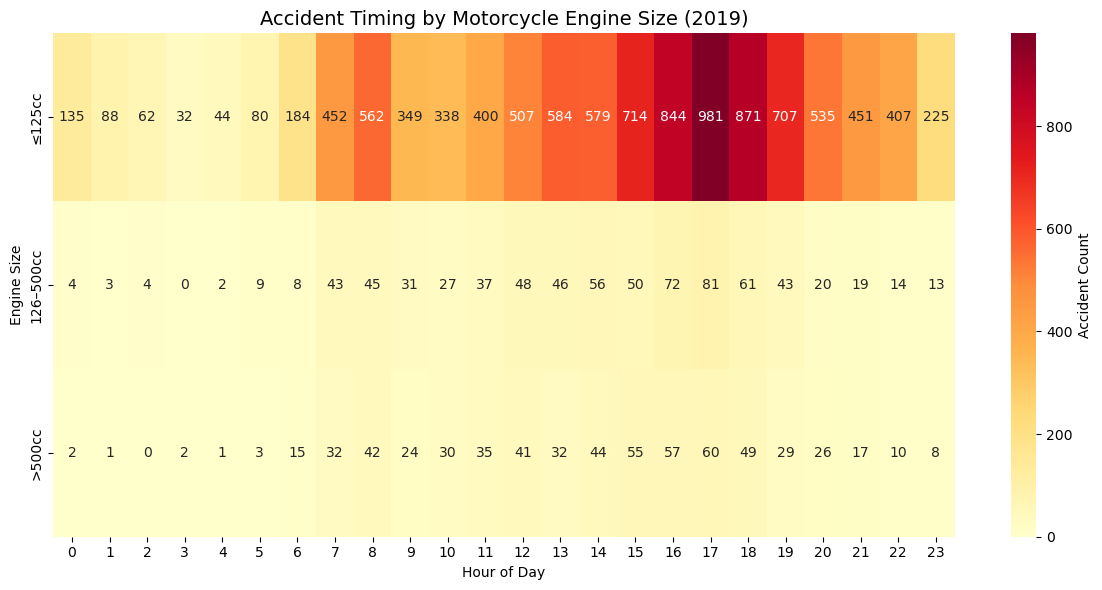

In [134]:
plt.figure(figsize=(12,6))
sns.heatmap(heat_data.T, cmap='YlOrRd', annot=True, fmt=".0f", cbar_kws={'label': 'Accident Count'})
plt.title("Accident Timing by Motorcycle Engine Size (2019)", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Engine Size")
plt.tight_layout()
plt.savefig('motorbike_accidents_by_hour_heatmap.png', dpi=300)
plt.show()

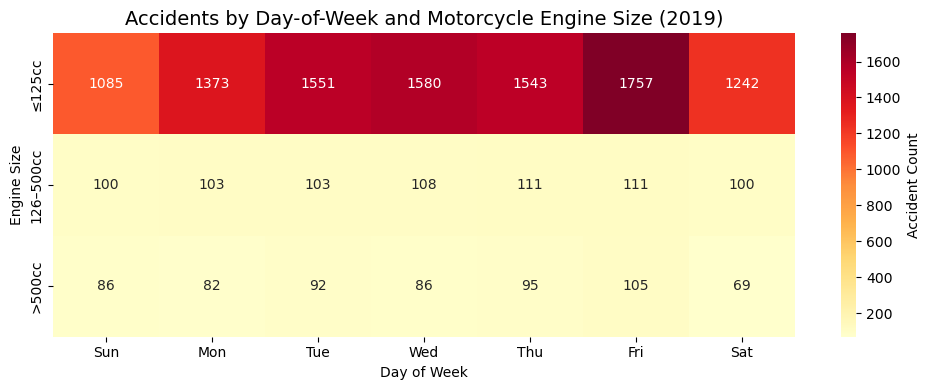

In [135]:
plt.figure(figsize=(10,4))
sns.heatmap(heat_data_day.T, cmap='YlOrRd', annot=True, fmt=".0f", cbar_kws={'label':'Accident Count'})
plt.title("Accidents by Day-of-Week and Motorcycle Engine Size (2019)", fontsize=14)
plt.xlabel("Day of Week")
plt.ylabel("Engine Size")
plt.tight_layout()
plt.savefig('motorbike_accidents_by_day_heatmap.png', dpi=300)
plt.show()

In [136]:
ped_df = pd.read_sql("""
    SELECT a.time, a.day_of_week, c.age_of_casualty
    FROM accident a
    JOIN casualty c ON a.accident_index = c.accident_index
    WHERE c.casualty_class = 2
      AND a.accident_year = 2019
""", conn)

# Extract hour from time column
ped_df['hour'] = pd.to_datetime(ped_df['time'], format='%H:%M', errors='coerce').dt.hour

print(ped_df.head())

    time  day_of_week  age_of_casualty  hour
0  17:50            2               -1    17
1  17:50            2               -1    17
2  01:50            3               21     1
3  00:40            3               16     0
4  02:45            3               41     2


Pedestrian Accidents by Hour:
hour
0      784
1      572
2      388
3      340
4      303
5      269
6      359
7      688
8     1278
9     1114
10    1513
11    1800
12    2102
13    2083
14    2138
15    2536
16    2518
17    2569
18    2043
19    1751
20    1450
21    1278
22    1217
23    1005
Name: count, dtype: int64


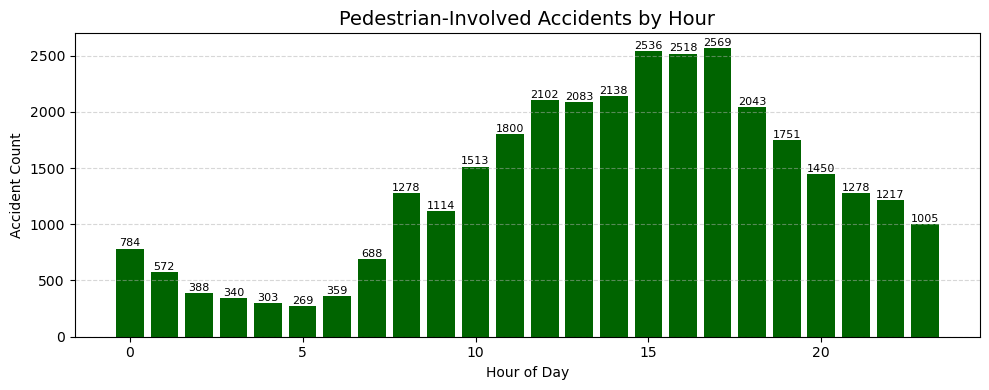

In [137]:
ped_hours = ped_df['hour'].value_counts().sort_index()
print("Pedestrian Accidents by Hour:")
print(ped_hours)

plt.figure(figsize=(10,4))
bars = plt.bar(ped_hours.index, ped_hours.values, color='darkgreen')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(int(height)), ha='center', va='bottom', fontsize=8)

plt.title("Pedestrian-Involved Accidents by Hour", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Accident Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('pedestrian_accidents_by_hour.png', dpi=300)
plt.show()


Pedestrian Accidents by Day of Week:
{'Sun': 4833, 'Mon': 4236, 'Tue': 4031, 'Wed': 4084, 'Thu': 4123, 'Fri': 5073, 'Sat': 5718}


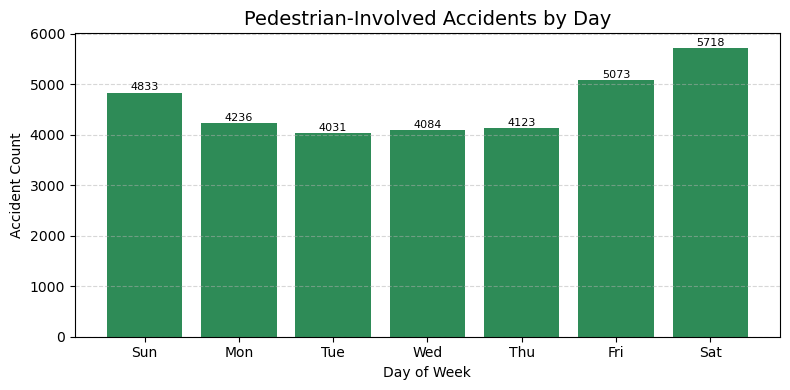

In [138]:
ped_days = ped_df['day_of_week'].value_counts().sort_index()
days = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
counts = [ped_days.get(i,0) for i in range(1,8)]
print("\nPedestrian Accidents by Day of Week:")
print(dict(zip(days, counts)))

plt.figure(figsize=(8,4))
bars = plt.bar(days, counts, color='seagreen')

# Annotate counts
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(int(height)), ha='center', va='bottom', fontsize=8)

plt.title("Pedestrian-Involved Accidents by Day", fontsize=14)
plt.xlabel("Day of Week")
plt.ylabel("Accident Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('pedestrian_accidents_by_day.png', dpi=300)
plt.show()


Pedestrian Accident Counts by Hour and Day:
      Sun  Mon  Tue  Wed  Thu  Fri  Sat
hour                                   
0     209   94   73   71   69   72  196
1     180   55   52   56   55   57  117
2     113   46   32   34   28   38   97
3     118   23   25   34   28   48   64
4      90   28   19   38   26   29   73
5      71   31   20   39   25   23   60
6      50   48   42   63   40   52   64
7      61  120  105  112  112  117   61
8      66  207  270  214  203  228   90
9     109  180  163  165  142  183  172
10    204  196  219  203  192  182  317
11    262  279  213  216  207  275  348
12    381  285  253  223  215  321  424
13    368  296  209  233  242  311  424
14    337  308  260  253  250  378  352
15    421  313  354  336  340  394  378
16    302  359  333  320  378  451  375
17    333  367  354  367  381  393  374
18    267  257  271  259  316  324  349
19    239  227  202  196  230  314  343
20    196  159  166  205  190  266  268
21    178  144  136  170  184  221 

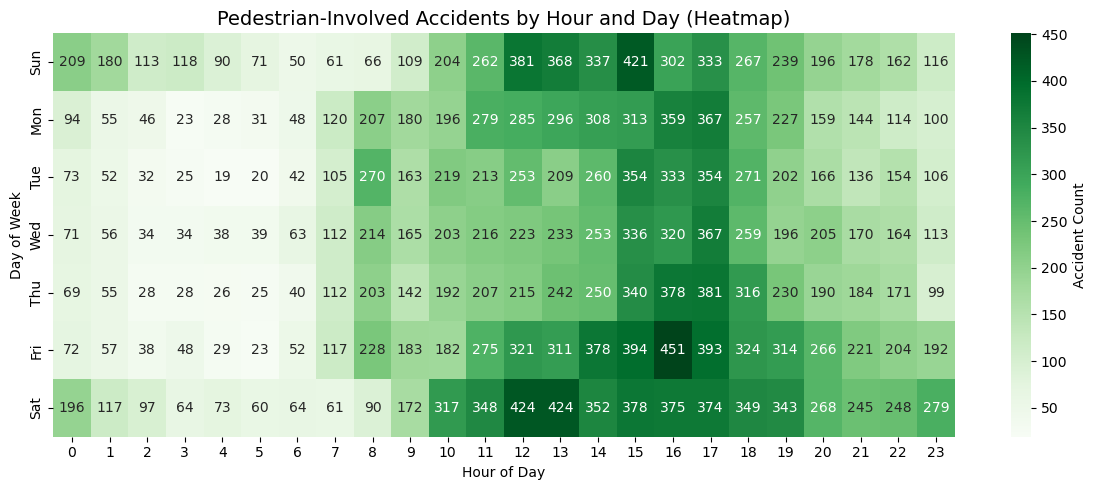

In [139]:
heat_data = pd.crosstab(ped_df['hour'], ped_df['day_of_week'])
heat_data = heat_data[[1,2,3,4,5,6,7]]  # order Mon-Sun
heat_data.columns = days

print("\nPedestrian Accident Counts by Hour and Day:")
print(heat_data)

plt.figure(figsize=(12,5))
sns.heatmap(heat_data.T, cmap='Greens', annot=True, fmt=".0f", cbar_kws={'label':'Accident Count'})
plt.title("Pedestrian-Involved Accidents by Hour and Day (Heatmap)", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.savefig('pedestrian_accidents_hour_day_heatmap.png', dpi=300)
plt.show()

Total Pedestrian Casualties by Age Group (2019):
age_group
Child (0-12)            6715
Teen (13-18)            3997
Young Adult (19-25)     5231
Adult (26-65)          12710
Elderly (65+)           3445
Name: count, dtype: int64


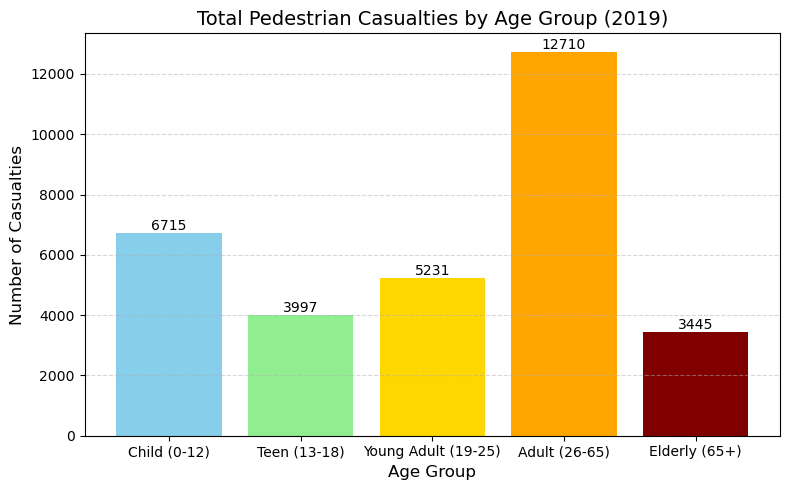

In [140]:
def age_group(age):
    if age <= 12:
        return 'Child (0-12)'
    elif 13 <= age <= 18:
        return 'Teen (13-18)'
    elif 19 <= age <= 25:
        return 'Young Adult (19-25)'
    elif 26 <= age <= 65:
        return 'Adult (26-65)'
    else:
        return 'Elderly (65+)'

# Apply grouping
ped_df['age_group'] = ped_df['age_of_casualty'].apply(age_group)

# Count casualties by age group (ordered properly)
age_order = ['Child (0-12)','Teen (13-18)','Young Adult (19-25)',
             'Adult (26-65)','Elderly (65+)']
age_counts = ped_df['age_group'].value_counts().reindex(age_order).fillna(0)

print("Total Pedestrian Casualties by Age Group (2019):")
print(age_counts.astype(int))

# Plot bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(age_counts.index, age_counts.values, 
               color=['skyblue','lightgreen','gold','orange','maroon'])

# Annotate counts on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(int(height)),
             ha='center', va='bottom', fontsize=10)

plt.title("Total Pedestrian Casualties by Age Group (2019)", fontsize=14)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Number of Casualties", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('pedestrian_casualties_by_age_group.png', dpi=300)
plt.show()

In [141]:
query = """
SELECT 
    a.accident_index,
    a.day_of_week,
    a.light_conditions,
    a.time,
    a.weather_conditions,
    a.road_type,
    a.accident_severity,
    c.casualty_class,
    v.vehicle_type
FROM accident a
LEFT JOIN casualty c ON a.accident_index = c.accident_index
LEFT JOIN vehicle v ON a.accident_index = v.accident_index
WHERE a.accident_year = 2019
"""

df = pd.read_sql(query, conn)

# Optional: check the first rows
print(df.head())

  accident_index  day_of_week  light_conditions   time  weather_conditions  \
0  2019010128300            2                 1  17:50                   1   
1  2019010128300            2                 1  17:50                   1   
2  2019010128300            2                 1  17:50                   1   
3  2019010128300            2                 1  17:50                   1   
4  2019010128300            2                 1  17:50                   1   

   road_type  accident_severity  casualty_class  vehicle_type  
0          1                  3               1             9  
1          1                  3               1             9  
2          1                  3               2             9  
3          1                  3               2             9  
4          1                  3               2             9  


Frequent Itemsets (support >= 0.01):
      support            itemsets
0    0.976159                 (1)
14   0.779856            (Slight)
8    0.766448                 (6)
28   0.763018         (Slight, 1)
11   0.750496                 (9)
..        ...                 ...
137  0.010146          (11, 6, 2)
186  0.010139           (6, 8, 3)
311  0.010139  (6, Slight, 3, 19)
225  0.010129  (11, Slight, 1, 2)
348  0.010072   (4, Slight, 7, 3)

[450 rows x 2 columns]

Top 15 Rules Impacting Accident Severity:
                  rule  support  confidence   lift
734  1, 2 → 11, Slight    0.010       0.025  1.692
735  11 → 1, Slight, 2    0.010       0.542  1.669
707     2 → 11, Slight    0.011       0.024  1.667
737  2 → 1, 11, Slight    0.010       0.023  1.653
705     11 → Slight, 2    0.011       0.562  1.653
732  11, 1 → Slight, 2    0.010       0.560  1.646
513      8 → 4, Slight    0.016       0.361  1.375
663   8 → 6, 4, Slight    0.011       0.258  1.364
658   6, 8 → 4, Slight    0.0

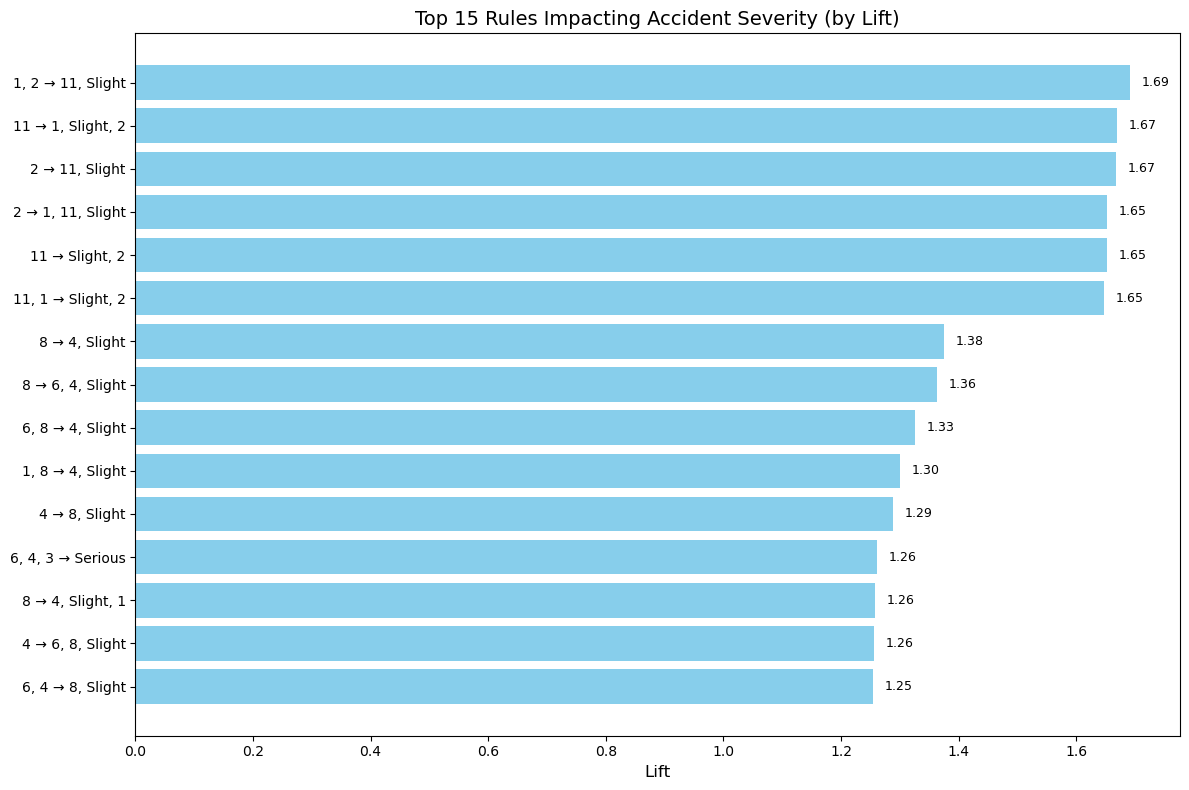

In [142]:
severity_map = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}
if df['accident_severity'].dtype != object:
    df['accident_severity'] = df['accident_severity'].map(severity_map)

# Prepare transactions for Apriori 
cat_cols = ['day_of_week', 'light_conditions', 'weather_conditions', 
            'road_type', 'accident_severity', 'casualty_class', 'vehicle_type']
df_cat = df[cat_cols].astype(str)
transactions = df_cat.values.tolist()

# One-hot encode
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_ohe = pd.DataFrame(te_ary, columns=te.columns_)

#  Frequent Itemsets 
frequent_itemsets = apriori(df_ohe, min_support=0.01, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
print("Frequent Itemsets (support >= 0.01):")
print(frequent_itemsets)

# Association Rules 
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

# Filter for accident severity in consequents
rules_severity = rules[rules['consequents'].astype(str).str.contains('accident_severity|Fatal|Serious|Slight')]
rules_severity = rules_severity.sort_values(by='lift', ascending=False).head(15)

# Add readable rule column
rules_severity['rule'] = rules_severity['antecedents'].apply(lambda x: ', '.join(list(x))) + \
                         " → " + rules_severity['consequents'].apply(lambda x: ', '.join(list(x)))

# Select key columns
rules_severity_df = rules_severity[['rule', 'support', 'confidence', 'lift']]

# Print neatly as DataFrame
print("\nTop 15 Rules Impacting Accident Severity:")
print(rules_severity_df.round(3))   # rounded for readability


# Horizontal Bar Plot: Top Rules by Lift 
rules_severity_sorted = rules_severity.sort_values(by='lift', ascending=True)

plt.figure(figsize=(12,8))
bars = plt.barh(rules_severity_sorted['rule'], rules_severity_sorted['lift'], color='skyblue')
plt.xlabel("Lift", fontsize=12)
plt.title("Top 15 Rules Impacting Accident Severity (by Lift)", fontsize=14)

# Annotate lift values on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2, f"{width:.2f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()


Accident severity counts by light conditions:
accident_severity  Fatal  Serious  Slight
light_conditions                         
-1                     0        0       1
 1                  3706    40664  166858
 4                   986    12304   46842
 5                    71      459    1648
 6                   973     5084   10177
 7                    75      748    4983


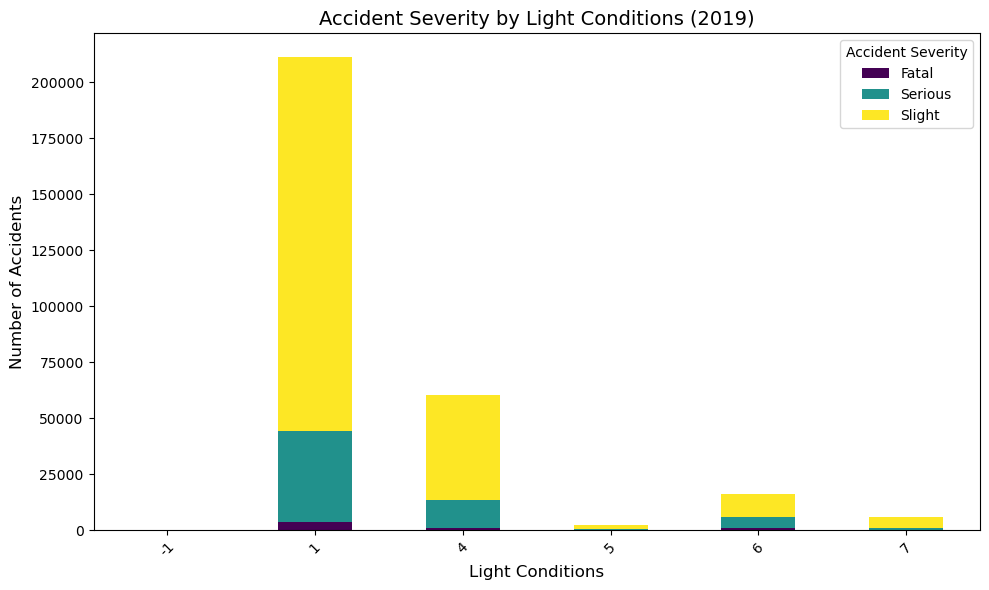

In [143]:
# Stacked Bar Plot: Accident Severity by Light Conditions 
severity_counts = df.groupby(['light_conditions', 'accident_severity']).size().unstack(fill_value=0)
print("\nAccident severity counts by light conditions:")
print(severity_counts)

severity_counts.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')
plt.title("Accident Severity by Light Conditions (2019)", fontsize=14)
plt.xlabel("Light Conditions", fontsize=12)
plt.ylabel("Number of Accidents", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Accident Severity')
plt.tight_layout()
plt.show()

In [144]:
districts = pd.read_sql("""
SELECT DISTINCT local_authority_district
FROM accident
""", conn)
print("Unique local_authority_district values:")
print(districts)

# Check unique ONS codes
ons_districts = pd.read_sql("""
SELECT DISTINCT local_authority_ons_district
FROM accident
""", conn)
print("nUnique local_authority_ons_district values:")
print(ons_districts)
ons_districts

Unique local_authority_district values:
     local_authority_district
0                          32
1                           1
2                           5
3                           4
4                          24
..                        ...
376                       931
377                       919
378                       937
379                       917
380                        -1

[381 rows x 1 columns]
nUnique local_authority_ons_district values:
    local_authority_ons_district
0                      E09000010
1                      E09000033
2                      E09000030
3                      E09000012
4                      E09000027
..                           ...
378                    S12000008
379                    S12000028
380                    S12000006
381                    E07000244
382                    E07000245

[383 rows x 1 columns]


,local_authority_ons_district
0,E09000010
1,E09000033
2,E09000030
3,E09000012
4,E09000027
...,...
378,S12000008
379,S12000028
380,S12000006
381,E07000244


In [145]:
query = """
SELECT
    accident_index,
    accident_year,
    accident_severity,
    longitude,
    latitude,
    speed_limit,
    urban_or_rural_area,
    lsoa_of_accident_location
FROM accident
WHERE accident_year = 2019
  AND local_authority_ons_district IN ('E06000010', 'E06000011')
  AND longitude IS NOT NULL
  AND latitude IS NOT NULL
"""

# Read into DataFrame
df = pd.read_sql(query, conn)

# Optional: check first rows
print(df.head())
print(f"Loaded {len(df)} accidents.")

  accident_index  accident_year  accident_severity  longitude   latitude  \
0  2019160354606           2019                  3  -0.387626  53.732399   
1  2019160805402           2019                  3  -0.447154  53.951956   
2  2019160805484           2019                  2  -0.371280  53.750902   
3  2019160805582           2019                  2  -0.046062  53.754377   
4  2019160805751           2019                  3  -0.274831  53.762138   

   speed_limit  urban_or_rural_area lsoa_of_accident_location  
0           30                    1                 E01012888  
1           40                    2                 E01012989  
2           30                    1                 E01012759  
3           30                    2                 E01013078  
4           20                    1                 E01012895  
Loaded 1475 accidents.


In [146]:
# Map severity
severity_map = {1:'Fatal', 2:'Serious', 3:'Slight'}
df['accident_severity'] = df['accident_severity'].map(severity_map)

coords = df[['longitude','latitude']].to_numpy()
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

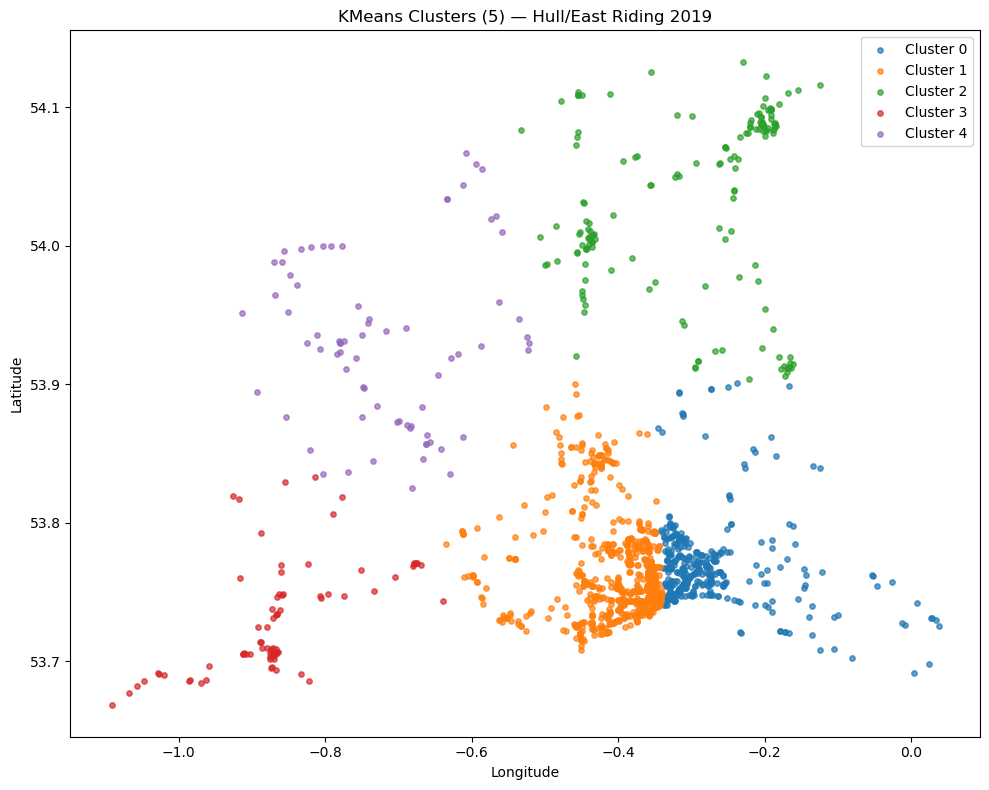

In [147]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['kmeans'] = kmeans.fit_predict(coords_scaled)

# Plot KMeans
plt.figure(figsize=(10,8))
cmap = get_cmap('tab10')
for label in range(5):
    mask = df['kmeans'] == label
    plt.scatter(df.loc[mask,'longitude'], df.loc[mask,'latitude'],
                s=15, alpha=0.7, label=f'Cluster {label}', c=[cmap(label % 10)])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMeans Clusters (5) — Hull/East Riding 2019')
plt.legend()
plt.tight_layout()
plt.show()

In [148]:
summary_kmeans = df.groupby('kmeans').agg(
    total_accidents=('accident_index','count'),
    fatal=('accident_severity', lambda x: (x=='Fatal').sum()),
    serious=('accident_severity', lambda x: (x=='Serious').sum()),
    slight=('accident_severity', lambda x: (x=='Slight').sum()),
    mean_speed=('speed_limit','mean')
).reset_index()
print("\nKMeans Cluster Summary:")
print(summary_kmeans)


KMeans Cluster Summary:
   kmeans  total_accidents  fatal  serious  slight  mean_speed
0       0              413      3       75     335   33.414044
1       1              749      8      137     604   34.379172
2       2              163      4       27     132   40.245399
3       3               77      3       15      59   47.532468
4       4               73      6       17      50   53.561644


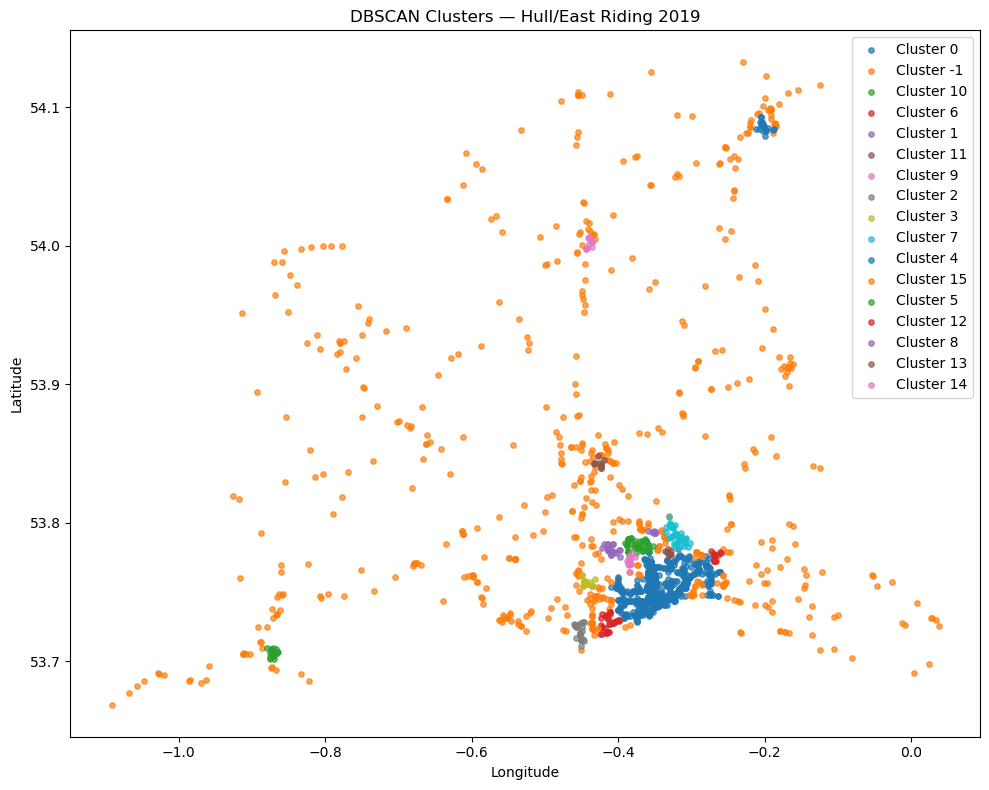

In [149]:
dbscan = DBSCAN(eps=0.05, min_samples=10)
df['dbscan'] = dbscan.fit_predict(coords_scaled)

# Plot DBSCAN
plt.figure(figsize=(10,8))
labels_db = df['dbscan'].unique()
for label in labels_db:
    mask = df['dbscan'] == label
    color = 'grey' if label == -1 else cmap(label % 10)
    plt.scatter(df.loc[mask,'longitude'], df.loc[mask,'latitude'],
                s=15, alpha=0.7, label=f'Cluster {label}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clusters — Hull/East Riding 2019')
plt.legend()
plt.tight_layout()
plt.show()

In [150]:
summary_db = df.groupby('dbscan').agg(
    total_accidents=('accident_index','count'),
    fatal=('accident_severity', lambda x: (x=='Fatal').sum()),
    serious=('accident_severity', lambda x: (x=='Serious').sum()),
    slight=('accident_severity', lambda x: (x=='Slight').sum()),
    mean_speed=('speed_limit','mean')
).reset_index()
print("\nDBSCAN Cluster Summary:")
print(summary_db)


DBSCAN Cluster Summary:
    dbscan  total_accidents  fatal  serious  slight  mean_speed
0       -1              595     16      123     456   44.773109
1        0              572      4       95     473   30.069930
2        1               10      0        1       9   34.000000
3        2               28      1        5      22   43.571429
4        3               18      0        2      16   30.555556
5        4               23      1        3      19   29.130435
6        5               15      0        2      13   26.000000
7        6               35      0        6      29   40.000000
8        7               39      1        5      33   30.000000
9        8               23      0        2      21   27.391304
10       9               10      0        1       9   29.000000
11      10               42      1       13      28   29.285714
12      11               11      0        1      10   28.181818
13      12               14      0        2      12   30.000000
14      13     

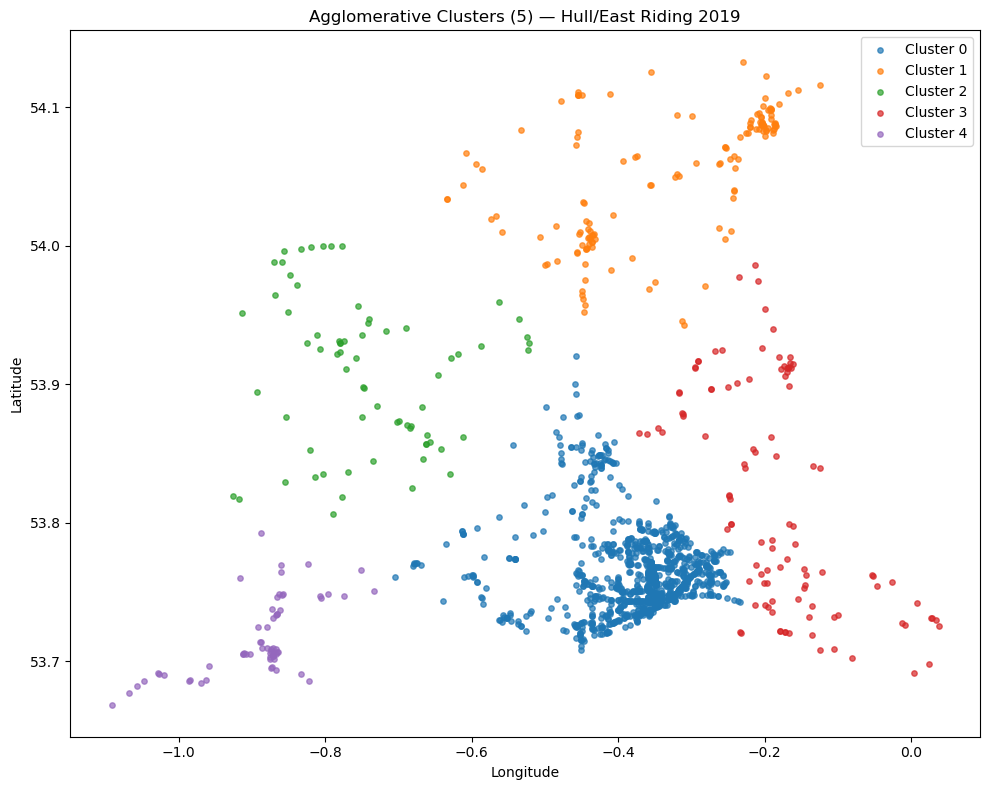

In [151]:
agglo = AgglomerativeClustering(n_clusters=5)
df['agglo'] = agglo.fit_predict(coords_scaled)

# Plot Agglomerative
plt.figure(figsize=(10,8))
for label in range(5):
    mask = df['agglo'] == label
    plt.scatter(df.loc[mask,'longitude'], df.loc[mask,'latitude'],
                s=15, alpha=0.7, label=f'Cluster {label}', c=[cmap(label % 10)])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Agglomerative Clusters (5) — Hull/East Riding 2019')
plt.legend()
plt.tight_layout()
plt.show()

In [152]:
summary_agglo = df.groupby('agglo').agg(
    total_accidents=('accident_index','count'),
    fatal=('accident_severity', lambda x: (x=='Fatal').sum()),
    serious=('accident_severity', lambda x: (x=='Serious').sum()),
    slight=('accident_severity', lambda x: (x=='Slight').sum()),
    mean_speed=('speed_limit','mean')
).reset_index()
print("\nAgglomerative Cluster Summary:")
print(summary_agglo)


Agglomerative Cluster Summary:
   agglo  total_accidents  fatal  serious  slight  mean_speed
0      0             1089     10      192     887   33.324151
1      1              146      5       29     112   40.890411
2      2               70      6       14      50   53.000000
3      3              107      1       24      82   45.046729
4      4               63      2       12      49   45.873016


In [153]:
acc

,time,date,day_of_week,accident_severity,local_authority_district,hour
0,17:50,18/02/2019,2,Slight,1,17
1,21:45,15/01/2019,3,Slight,9,21
2,01:50,01/01/2019,3,Slight,2,1
3,01:20,01/01/2019,3,Serious,2,1
4,00:40,01/01/2019,3,Slight,28,0
...,...,...,...,...,...,...
117531,01:00,18/05/2019,7,Slight,917,1
117532,08:46,30/05/2019,5,Slight,917,8
117533,15:30,21/06/2019,6,Slight,917,15
117534,14:10,29/06/2019,7,Slight,917,14


In [154]:
query = "SELECT DISTINCT police_force FROM accident"
unique_forces = pd.read_sql(query, conn)
print("Unique police_force values:")
print(unique_forces)

Unique police_force values:
    police_force
0              1
1             48
2              3
3              4
4              5
5              6
6              7
7             10
8             11
9             12
10            13
11            14
12            16
13            17
14            20
15            21
16            22
17            23
18            30
19            31
20            32
21            33
22            34
23            35
24            36
25            37
26            40
27            41
28            42
29            43
30            44
31            45
32            46
33            47
34            50
35            52
36            53
37            54
38            55
39            60
40            61
41            62
42            63
43            91
44            92
45            93
46            94
47            95
48            96
49            97
50            98
51            99


In [155]:
query = """
SELECT accident_index, police_force, date
FROM accident
WHERE accident_year BETWEEN 2017 AND 2019
  AND police_force IN (1, 10, 16)
"""
df = pd.read_sql(query, conn)

In [156]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

Metrics for Humberside:
  MAE:  4.86
  MSE:  61.36
  RMSE: 7.83
  R²:   0.800

Metrics for Metropolitan:
  MAE:  68.22
  MSE:  8066.39
  RMSE: 89.81
  R²:   0.794

Metrics for West Yorkshire:
  MAE:  5.66
  MSE:  75.82
  RMSE: 8.71
  R²:   0.795



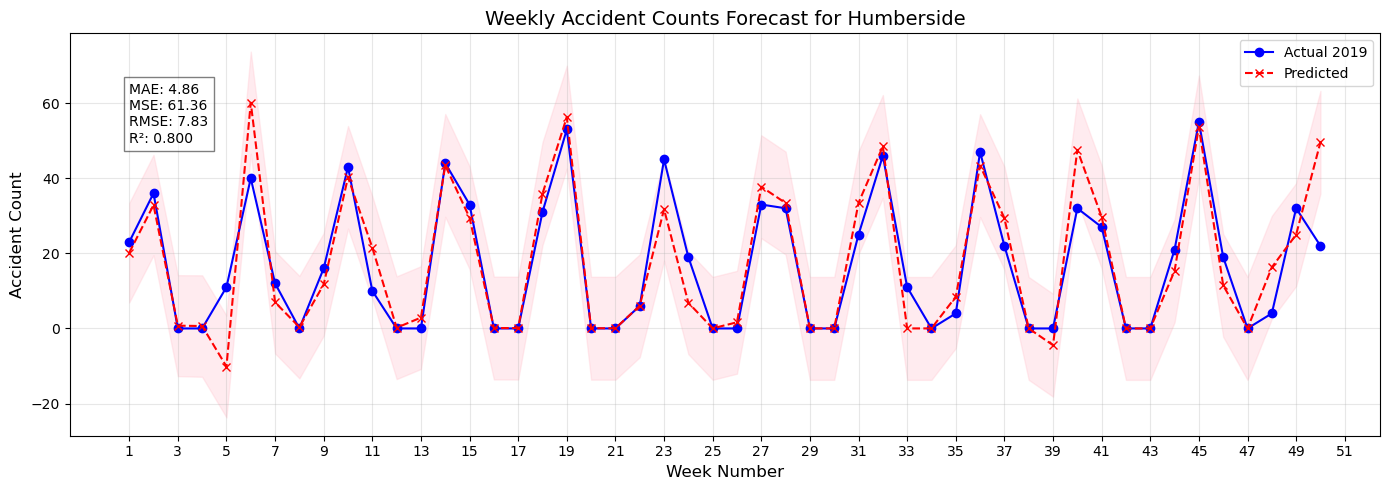

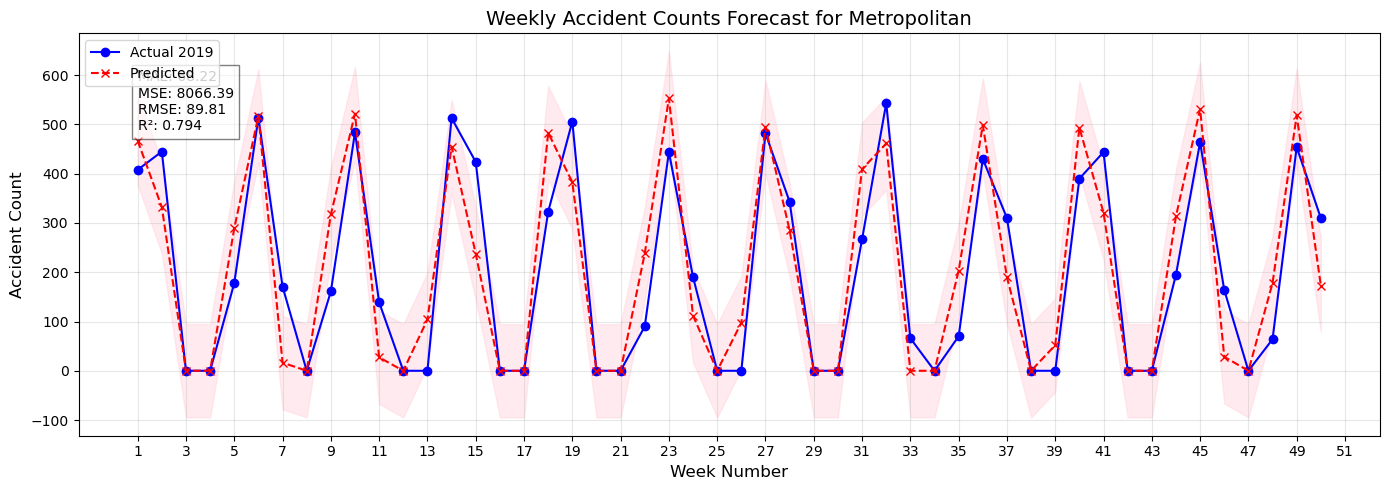

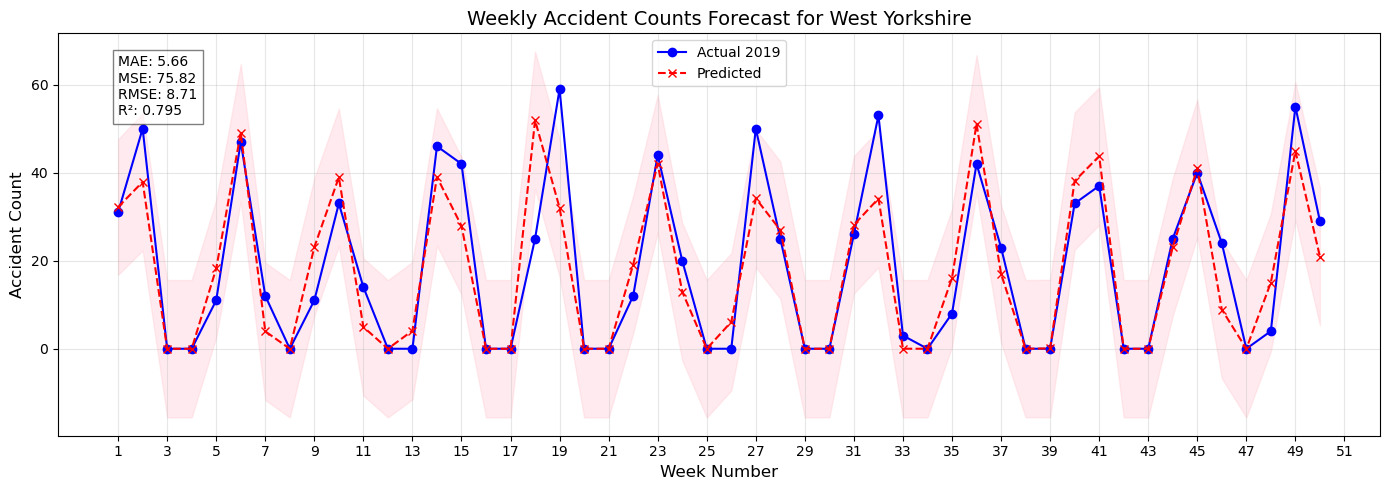

In [157]:
chosen_forces = [16, 1, 10]  # Humberside, Metropolitan, West Yorkshire
force_names = {16: "Humberside", 1: "Metropolitan", 10: "West Yorkshire"}

# Dictionary to store results
results = {}
metrics = {}

# --- Process each police force ---
for pf in chosen_forces:
    df_area = df[df['police_force'] == pf].copy()
    
    # Aggregate weekly counts
    weekly = df_area.set_index('date').resample('W').count()['accident_index']
    weekly.name = 'accidents'
    
    # Split into train (2017-2018) and test (2019)
    train = weekly[weekly.index.year < 2019]
    test = weekly[weekly.index.year == 2019]
    
    # Fit SARIMAX model
    model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,1,0,52))
    fit = model.fit(disp=False)
    
    # Forecast for 2019
    forecast = fit.get_forecast(steps=len(test))
    pred = forecast.predicted_mean
    ci = forecast.conf_int()
    
    # Store results
    results[pf] = {'train': train, 'test': test, 'pred': pred, 'ci': ci}
    
    # Calculate metrics
    mae = mean_absolute_error(test, pred)
    mse = mean_squared_error(test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(test, pred)
    
    metrics[pf] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}
    
    # Print metrics
    print(f"Metrics for {force_names[pf]}:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  MSE:  {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.3f}\n")

# --- Plot forecasts ---
for pf, data in results.items():
    comparison = pd.DataFrame({
        'Actual': data['test'],
        'Predicted': data['pred'],
        'Lower_CI': data['ci'].iloc[:,0],
        'Upper_CI': data['ci'].iloc[:,1]
    })

    # Week numbers for x-axis
    weeks = comparison.index.isocalendar().week
    
    plt.figure(figsize=(14,5))
    plt.plot(weeks, comparison['Actual'], label='Actual 2019', color='blue', marker='o')
    plt.plot(weeks, comparison['Predicted'], label='Predicted', color='red', linestyle='--', marker='x')
    plt.fill_between(weeks, comparison['Lower_CI'], comparison['Upper_CI'], color='pink', alpha=0.3)

    # Display metrics on plot
    plt.text(1, max(comparison['Actual'])*0.9, 
             f"MAE: {metrics[pf]['MAE']:.2f}\nMSE: {metrics[pf]['MSE']:.2f}\nRMSE: {metrics[pf]['RMSE']:.2f}\nR²: {metrics[pf]['R2']:.3f}",
             fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.title(f'Weekly Accident Counts Forecast for {force_names[pf]}', fontsize=14)
    plt.xlabel('Week Number', fontsize=12)
    plt.ylabel('Accident Count', fontsize=12)
    plt.xticks(range(1,53,2))  # every 2 weeks
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [158]:
acc

,time,date,day_of_week,accident_severity,local_authority_district,hour
0,17:50,18/02/2019,2,Slight,1,17
1,21:45,15/01/2019,3,Slight,9,21
2,01:50,01/01/2019,3,Slight,2,1
3,01:20,01/01/2019,3,Serious,2,1
4,00:40,01/01/2019,3,Slight,28,0
...,...,...,...,...,...,...
117531,01:00,18/05/2019,7,Slight,917,1
117532,08:46,30/05/2019,5,Slight,917,8
117533,15:30,21/06/2019,6,Slight,917,15
117534,14:10,29/06/2019,7,Slight,917,14


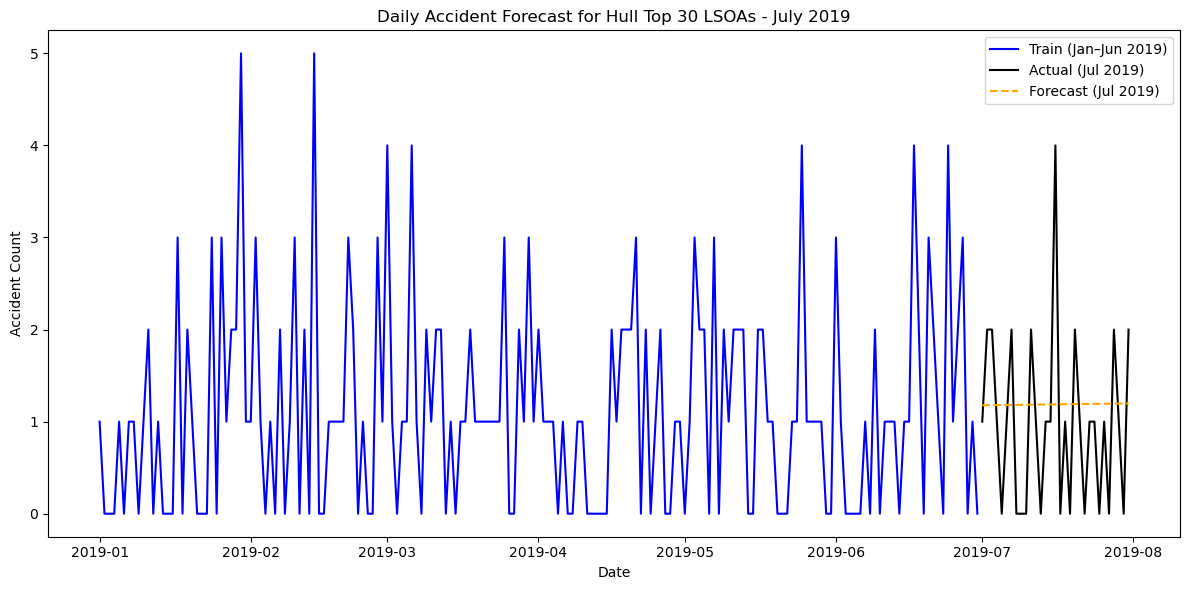

Holt-Winters Forecast Summary (Hull Top 30 LSOAs)
       daily_accidents
count       212.000000
mean          1.094340
std           1.101729
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           5.000000

Forecast Performance Metrics (July 2019):
MAE:  0.77
MSE:  0.92
RMSE: 0.96
R²:   -0.057

Actual vs Forecast (first 10 days of July 2019):
            Actual  Forecast
2019-07-01       1  1.177531
2019-07-02       2  1.178207
2019-07-03       2  1.178883
2019-07-04       1  1.179559
2019-07-05       0  1.180235
2019-07-06       1  1.180910
2019-07-07       2  1.181586
2019-07-08       0  1.182262
2019-07-09       0  1.182938
2019-07-10       0  1.183614


In [159]:
acc = pd.read_sql("""
    SELECT time, date, day_of_week, accident_severity, 
           local_authority_district, lsoa_of_accident_location
    FROM accident
    WHERE accident_year = 2019
""", conn)

# Convert date
acc['date'] = pd.to_datetime(acc['date'], format="%d/%m/%Y", errors='coerce')

# Keep only Hull (district 31) and valid LSOAs
acc_hull = acc[
    (acc['local_authority_district'] == 31) &
    (acc['lsoa_of_accident_location'] != -1)
]

# Top 30 LSOAs Jan–Mar 2019
top_30_lsoas = acc_hull[
    acc_hull['date'].between('2019-01-01', '2019-03-31')
]['lsoa_of_accident_location'].value_counts().nlargest(30).index

# Filter Jan–Jul 2019 for top 30 LSOAs
hull_top30_jan_jul = acc_hull[
    acc_hull['date'].between('2019-01-01', '2019-07-31') &
    acc_hull['lsoa_of_accident_location'].isin(top_30_lsoas)
]

# Aggregate daily counts
daily_counts = hull_top30_jan_jul.groupby('date').size().reindex(
    pd.date_range("2019-01-01", "2019-07-31"), fill_value=0
).rename("daily_accidents").to_frame()

# Train/test split
train = daily_counts[:'2019-06-30']
test = daily_counts['2019-07-01':]

# Fit Holt-Winters model (additive trend, no seasonality)
model = ExponentialSmoothing(train['daily_accidents'], trend='add', seasonal=None)
model_fit = model.fit()
forecast = model_fit.forecast(len(test))

#  Plot results 
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['daily_accidents'], label="Train (Jan–Jun 2019)", color="blue")
plt.plot(test.index, test['daily_accidents'], label="Actual (Jul 2019)", color="black")
plt.plot(test.index, forecast, label="Forecast (Jul 2019)", linestyle="--", color="orange")
plt.title("Daily Accident Forecast for Hull Top 30 LSOAs - July 2019")
plt.xlabel("Date")
plt.ylabel("Accident Count")
plt.legend()
plt.tight_layout()
plt.show()

# Forecast performance metrics 
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test, forecast)

print("Holt-Winters Forecast Summary (Hull Top 30 LSOAs)")
print(daily_counts.describe())

print("\nForecast Performance Metrics (July 2019):")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

#  Compare actual vs forecast in a table
comparison = pd.DataFrame({
    'Actual': test['daily_accidents'],
    'Forecast': forecast
})
print("\nActual vs Forecast (first 10 days of July 2019):")
print(comparison.head(10))

# B

In [162]:
edges = pd.read_csv('facebook_combined.txt', sep=' ', header=None, names=['source','target'])

# Create an undirected graph
G = nx.from_pandas_edgelist(edges, 'source', 'target')

#  Basic network characteristics 
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
avg_degree = sum(dict(G.degree()).values()) / num_nodes

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Network density: {density:.4f}")
print(f"Average degree: {avg_degree:.2f}")

Number of nodes: 4039
Number of edges: 88234
Network density: 0.0108
Average degree: 43.69


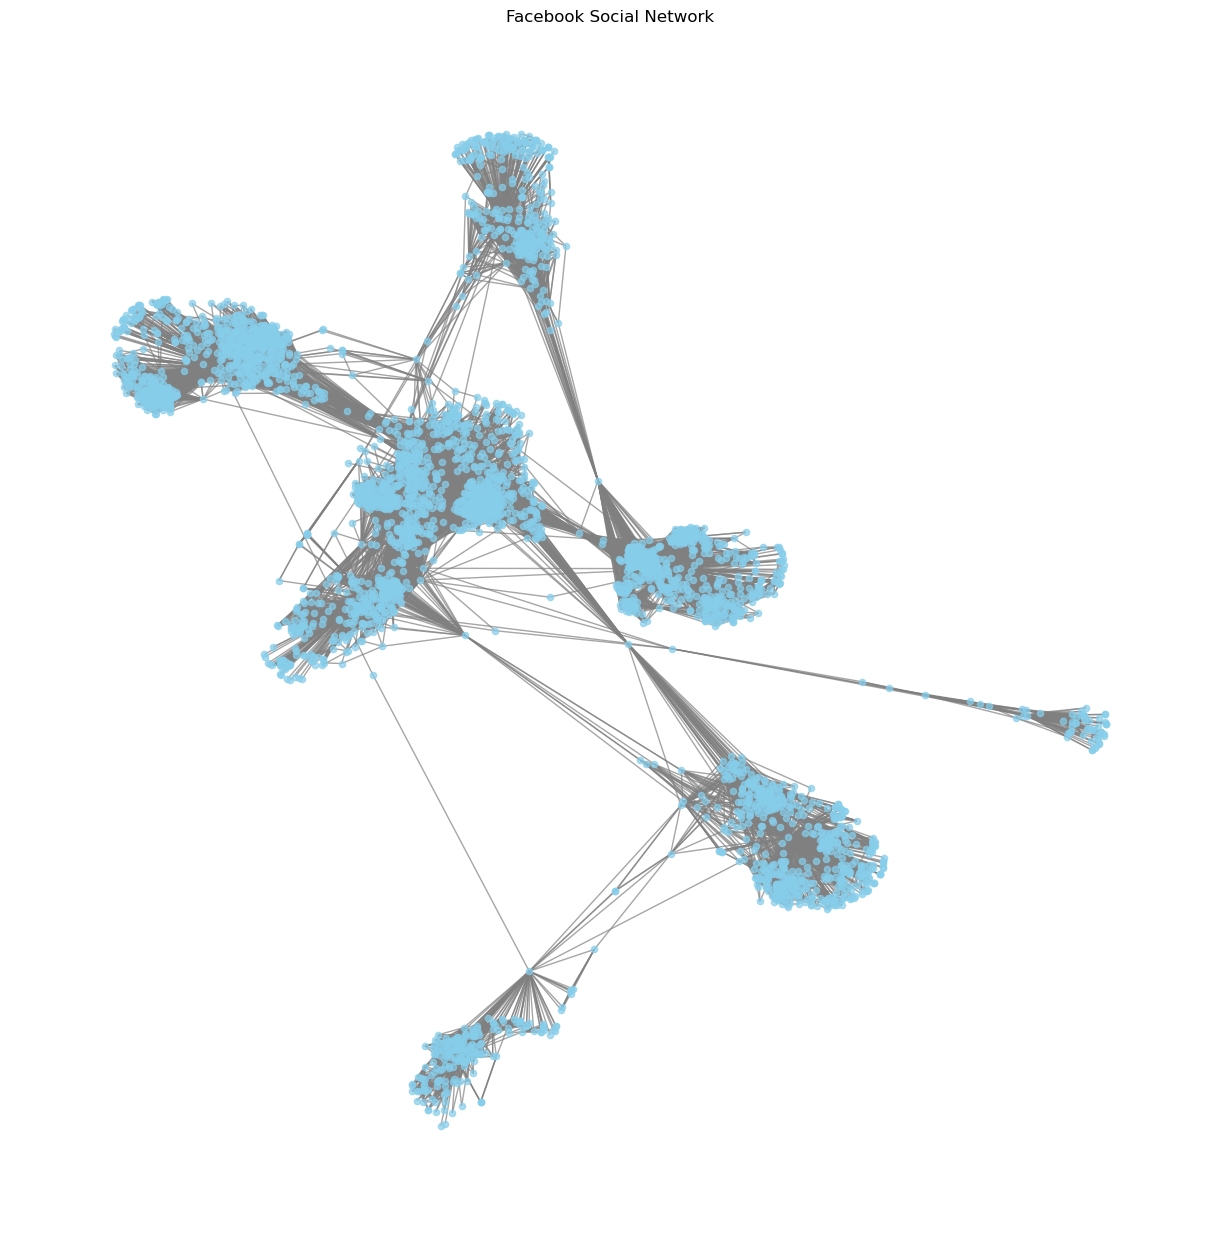

Average clustering coefficient: 0.606
Average path length: 3.6925068496963913
Number of communities detected: 13
Modularity (greedy): 0.777


In [163]:
# Full network visualization
plt.figure(figsize=(12,12))
nx.draw(
    G,
    node_size=20,
    node_color='skyblue',
    edge_color='gray',
    with_labels=False,
    alpha=0.7
)
plt.title("Facebook Social Network")
plt.show()

# Detect communities 
communities = list(greedy_modularity_communities(G))
largest_comm = max(communities, key=len)
subgraph = G.subgraph(largest_comm)

#  Network metrics 
clustering_coeff = nx.average_clustering(G)
avg_path_length = nx.average_shortest_path_length(G) if nx.is_connected(G) else "Graph not connected"
modularity = nx.community.modularity(G, greedy_modularity_communities(G))

print(f"Average clustering coefficient: {clustering_coeff:.3f}")
print(f"Average path length: {avg_path_length}")
print(f"Number of communities detected: {len(communities)}")
print(f"Modularity (greedy): {modularity:.3f}")

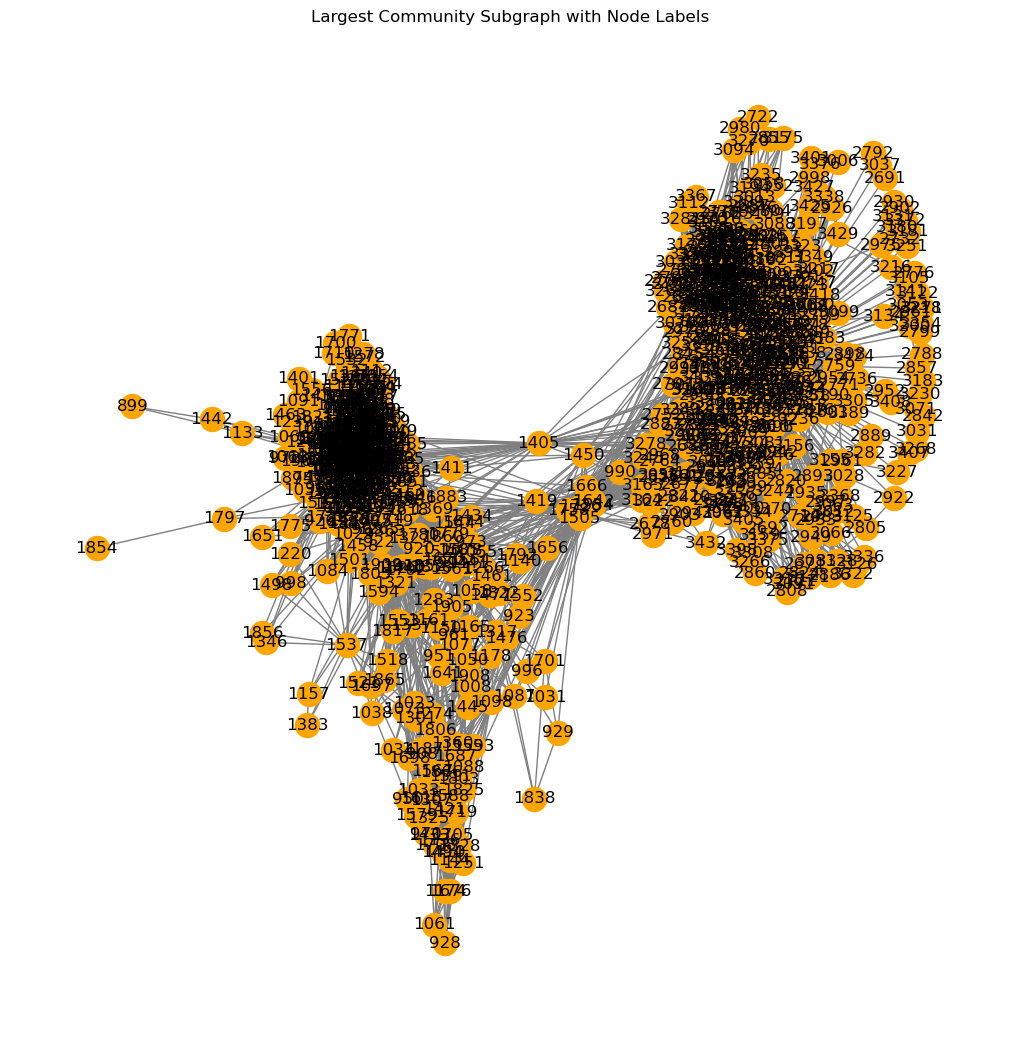

In [164]:
#  Subgraph of largest community with labels 
pos_sub = nx.spring_layout(subgraph, seed=42)
plt.figure(figsize=(10,10))
nx.draw(
    subgraph,
    pos_sub,
    node_color='orange',
    node_size=300,
    edge_color='gray',
    with_labels=True
)
plt.title("Largest Community Subgraph with Node Labels")
plt.show()

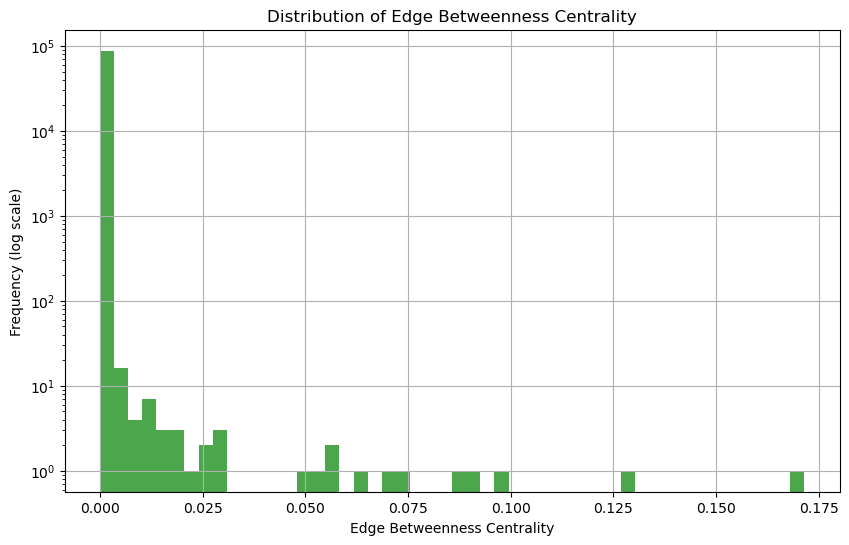

Max edge betweenness: 0.171493
Mean edge betweenness: 0.000042


In [165]:
# Edge betweenness centrality
edge_betweenness = nx.edge_betweenness_centrality(G)

# Plot distribution
centrality_values = list(edge_betweenness.values())
plt.figure(figsize=(10, 6))
plt.hist(centrality_values, bins=50, log=True, color='green', alpha=0.7)
plt.title("Distribution of Edge Betweenness Centrality")
plt.xlabel("Edge Betweenness Centrality")
plt.ylabel("Frequency (log scale)")
plt.grid(True)
plt.show()

# Summary stats for centrality
print(f"Max edge betweenness: {max(centrality_values):.6f}")
print(f"Mean edge betweenness: {np.mean(centrality_values):.6f}")

In [166]:
# Greedy Modularity
communities_greedy = sorted(greedy_modularity_communities(G), key=len, reverse=True)
num_communities_greedy = len(communities_greedy)
sizes_greedy = [len(c) for c in communities_greedy]

print(f"Greedy Modularity: {num_communities_greedy} communities")
print("Community sizes (descending):", sizes_greedy)

# Label Propagation (note: can be stochastic, run multiple times if needed)
communities_lp = list(label_propagation_communities(G))
communities_lp = sorted(communities_lp, key=len, reverse=True)
num_communities_lp = len(communities_lp)
sizes_lp = [len(c) for c in communities_lp]

print(f"Label Propagation: {num_communities_lp} communities")
print("Community sizes (descending):", sizes_lp)

# Comparison
print("\nComparison:")
print("Greedy tends to find fewer, larger communities optimizing modularity.")
print("Label Propagation may find more variable sizes due to local propagation.")

Greedy Modularity: 13 communities
Community sizes (descending): [983, 815, 548, 543, 372, 219, 208, 206, 59, 37, 25, 18, 6]
Label Propagation: 44 communities
Community sizes (descending): [1030, 753, 547, 469, 226, 215, 198, 179, 60, 49, 36, 34, 25, 19, 16, 14, 13, 12, 10, 10, 10, 9, 9, 8, 8, 8, 8, 7, 7, 6, 6, 6, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2]

Comparison:
Greedy tends to find fewer, larger communities optimizing modularity.
Label Propagation may find more variable sizes due to local propagation.


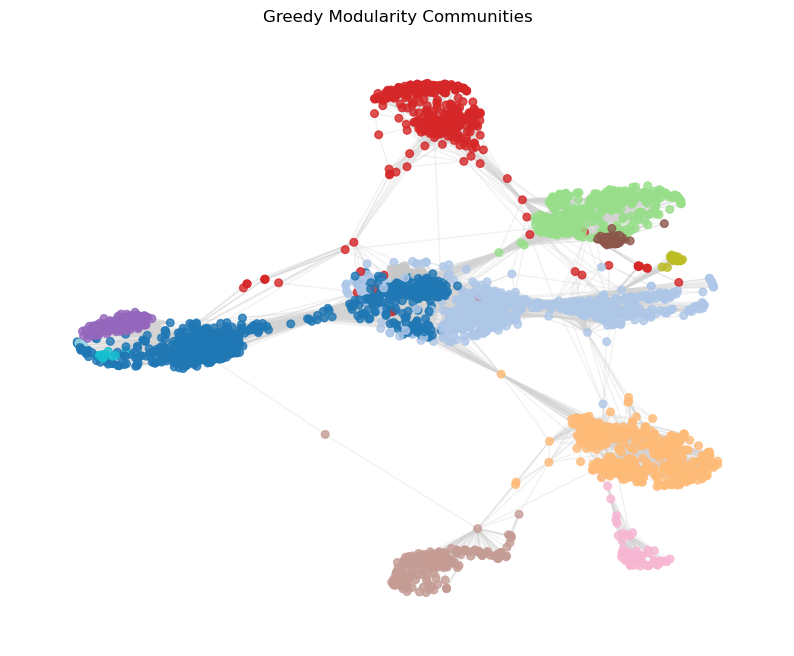

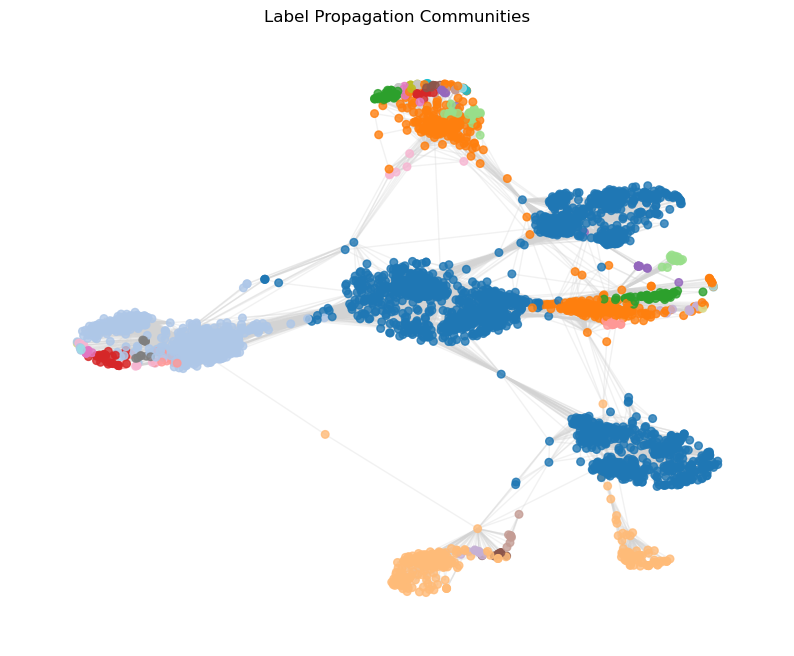

In [167]:
color_map_greedy = {}
for i, comm in enumerate(communities_greedy):
    for node in comm:
        color_map_greedy[node] = i

node_colors_greedy = [color_map_greedy[node] for node in G.nodes()]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # force-directed layout
nx.draw_networkx_nodes(G, pos, node_color=node_colors_greedy, cmap=plt.cm.tab20,
                       node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color="lightgray", alpha=0.3)
plt.title("Greedy Modularity Communities")
plt.axis("off")
plt.show()


# --- FIGURE B3: Label Propagation Communities ---
color_map_lp = {}
for i, comm in enumerate(communities_lp):
    for node in comm:
        color_map_lp[node] = i

node_colors_lp = [color_map_lp[node] for node in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors_lp, cmap=plt.cm.tab20,
                       node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color="lightgray", alpha=0.3)
plt.title("Label Propagation Communities")
plt.axis("off")
plt.show()